In [9]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy import stats
from hmmBaumWelch import BaumWelch

In [10]:
def plot_hmm_results(df, Z_inference, gamma_meanR):

    # Creating the main plot
    fig, ax1 = plt.subplots()

    # Plotting the bar chart
    ax1.scatter(df['x'],df['j'], color='cyan', alpha=0.6, label='j')
    ax1.scatter(df['x'],df['y'], color='teal', alpha=0.6, label='y')
    ax1.scatter(df['x'],df['z'], color='salmon', alpha=0.6, label='z')

    ax1.set_xlabel("t")
    ax1.set_ylabel('Observable')

    plt.legend(loc='upper left')

    # Creating a secondary y-axis on the right side
    ax2 = ax1.twinx()
    ax3 = ax1.twinx()

    ax2.plot(df['x'],Z_inference[0,:], color='grey', linestyle='-', label='$Z_{infer}$')
    ax2.set_ylim(-0.2,2.2)


  
    ax3.plot(df['x'],gamma_meanR[1,:], color='black', alpha = 0.7, linestyle='--', label='$P(Z_{1})$')

    if gamma_meanR.shape[0]==3:
        ax3.plot(df['x'],gamma_meanR[2,:], color='black', alpha=0.7, linestyle=':', label='$P(Z_{2})$')

    ax3.set_ylabel('$P(Z_{1})$', color='black')      

    if gamma_meanR.shape[0]==3:
        ax3.set_ylim(-0.1,2.1)
    else:
        ax3.set_ylim(-0.1,1.1)

    # right, left, top, bottom
    ax3.spines['right'].set_position(('outward', 60))

    plt.legend(loc='upper right')
    plt.show()

### Synthesize time series data from three probability distributions

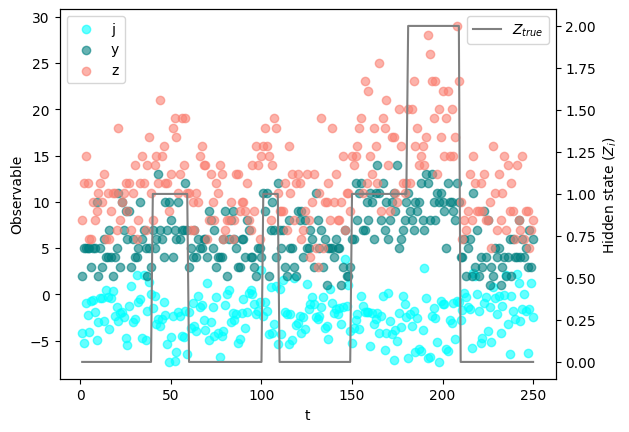

In [11]:
# create some synthetic data from Poisson distributions
np.random.seed(1)

# mu_scales = [1.0, 2.0, 3.0]
mu_scales = [1.0, 1.5, 2.0]
mu_j, sigma_j = -2, 2
mu_y = 5
mu_z = 10

x = [x for x in range(1,251)]
j = []
y = []
z = []
Z = []
for xi in x:
    if ((xi>=40) and (xi<60)) or ((xi>100) and (xi<110)):
        Zi = 1
        yi = stats.poisson.rvs(mu_y * mu_scales[Zi])
        zi = stats.poisson.rvs(mu_z * mu_scales[Zi])
        ji = stats.norm.rvs(loc=mu_j * mu_scales[Zi], scale=sigma_j)
    elif ((xi>=150) and (xi<=180)):
        Zi = 1
        yi = stats.poisson.rvs(mu_y * mu_scales[Zi])
        zi = stats.poisson.rvs(mu_z * mu_scales[Zi])
        ji = stats.norm.rvs(loc=mu_j * mu_scales[Zi], scale=sigma_j)
    elif ((xi>180) and (xi<210)):
        Zi = 2
        yi = stats.poisson.rvs(mu_y * mu_scales[Zi])
        zi = stats.poisson.rvs(mu_z * mu_scales[Zi])
        ji = stats.norm.rvs(loc=mu_j * mu_scales[Zi], scale=sigma_j)
    else:
        Zi = 0
        yi = stats.poisson.rvs(mu_y * mu_scales[Zi])
        zi = stats.poisson.rvs(mu_z * mu_scales[Zi])
        ji = stats.norm.rvs(loc=mu_j * mu_scales[Zi], scale=sigma_j)

    j.append(ji)
    y.append(yi)
    z.append(zi)
    Z.append(Zi)

df = pd.DataFrame(
    data={
        'j': j,
        'x': x, 
        'y': y,
        'z': z,
        'Z': Z,
        })

# Creating the main plot
fig, ax1 = plt.subplots()

# Plotting the bar chart
ax1.scatter(df['x'],df['j'], color='cyan', label='j', alpha=0.6)
ax1.scatter(df['x'],df['y'], color='teal', label='y', alpha=0.6)
ax1.scatter(df['x'],df['z'], color='salmon', label='z', alpha=0.6)

ax1.set_xlabel("t")
ax1.set_ylabel('Observable')

plt.legend(loc='upper left')

# Creating a secondary y-axis on the right side
ax2 = ax1.twinx()
ax2.plot(df['x'],df['Z'], color='grey', label='$Z_{true}$', alpha=1.0)
ax2.set_ylabel('Hidden state $(Z_{i})$')
plt.legend(loc='upper right')
plt.show()

### HMM example: One observed variable (y) and two hidden state {Z0, Z1}

#### Discrete variables

We can define the priors as either arrays or Scipy functions. We will mostly work through examples with Scipy functions, but it should be known the arrays can be passed directly to the BaumWelch object if preferred.

Below we define two Poisson distributions for the two hidden states.

Early stopping converged on iteration 9.


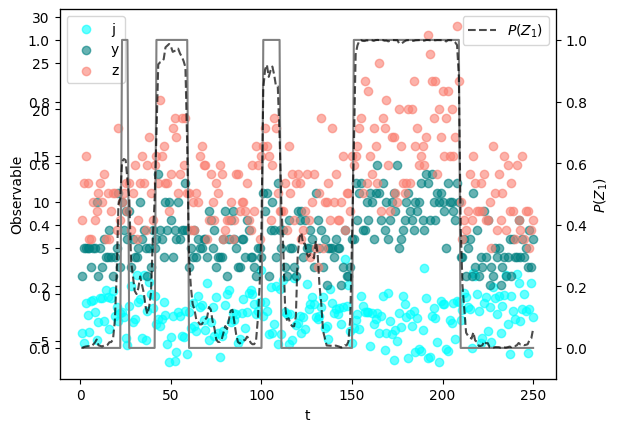

In [12]:
# define the Scipy functions
B_y_Z0 = stats.poisson(mu_y*mu_scales[0])
B_y_Z1 = stats.poisson(mu_y*mu_scales[1])

# store in correct format: list[tuple]
B_list = [(B_y_Z0, B_y_Z1)]
O_list = [df['y'].tolist()]

# create the BaumWelch (HMM) object
HMM = BaumWelch(
                    Z = {0,1},
                    O_list = O_list,
                    pi=[0.5, 0.5],
                    A=np.array([[0.8, 0.2], 
                                [0.2, 0.8]]),
                    B_list=B_list,
                )

# perform expectation maximisation
HMM.baumwelch_expectationMaximisation(iter=50, update_pi=True, update_A=True, update_B=False, early_stopping=True)

# inference
_, _, Z_inference, gamma_meanR = HMM.Z_state_probs_inference()


plot_hmm_results(df, Z_inference, gamma_meanR)

#### Continuous variables

We are generally picking out two states, but there is uncertainty and noise. Let's try using the continuous variable j instead.

Early stopping converged on iteration 36.


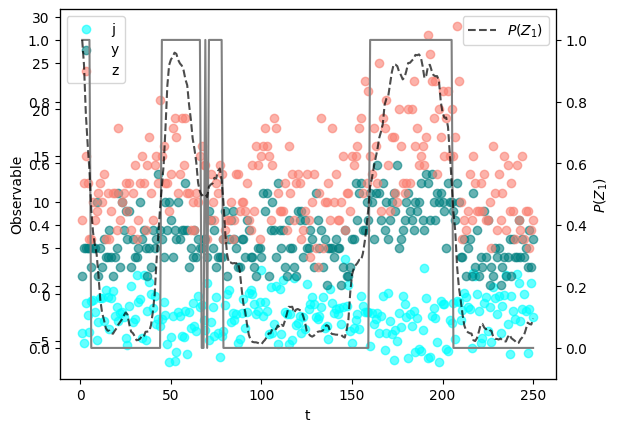

In [13]:
# define the Scipy functions
B_j_Z0 = stats.norm(mu_j*mu_scales[0], sigma_j)
B_j_Z1 = stats.norm(mu_j*mu_scales[1], sigma_j)

# store in correct format: list[tuple]
B_list = [(B_j_Z0, B_j_Z1)]
O_list = [df['j'].tolist()]

# create the BaumWelch (HMM) object
HMM = BaumWelch(
                    Z = {0,1},
                    O_list = O_list,
                    pi=[0.5, 0.5],
                    A=np.array([[0.8, 0.2], 
                                [0.2, 0.8]]),
                    B_list=B_list,
                )

# perform expectation maximisation
HMM.baumwelch_expectationMaximisation(iter=50, update_pi=True, update_A=True, update_B=False)

# inference
_, _, Z_inference, gamma_meanR = HMM.Z_state_probs_inference()

plot_hmm_results(df, Z_inference, gamma_meanR)

#### Multiple variables: discrete and continuous combined

Inference from single variables brings uncertainty. But we can perform inference on several variables at once. Let's work through an example using both j and y, and then after, an example with j, y, and z.

Early stopping converged on iteration 14.


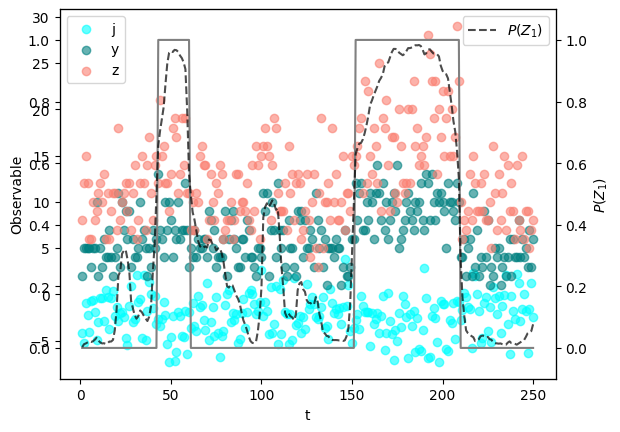

In [14]:
# define the Scipy functions
B_j_Z0 = stats.norm(mu_j*mu_scales[0], sigma_j)
B_j_Z1 = stats.norm(mu_j*mu_scales[1], sigma_j)

B_y_Z0 = stats.poisson(mu_y*mu_scales[0])
B_y_Z1 = stats.poisson(mu_y*mu_scales[1])

# store in correct format: list[tuple]
B_list = [(B_j_Z0, B_j_Z1), (B_y_Z0, B_y_Z1)]
O_list = [df['j'].tolist(), df['y'].tolist()]

# create the BaumWelch (HMM) object
HMM = BaumWelch(
                    Z = {0,1},
                    O_list = O_list,
                    pi=[0.5, 0.5],
                    A=np.array([[0.8, 0.2], 
                                [0.2, 0.8]]),
                    B_list=B_list,
                )

# perform expectation maximisation
HMM.baumwelch_expectationMaximisation(iter=50, update_pi=True, update_A=True, update_B=False)

# inference
_, _, Z_inference, gamma_meanR = HMM.Z_state_probs_inference()

plot_hmm_results(df, Z_inference, gamma_meanR)

And using all 3.

Early stopping converged on iteration 13.


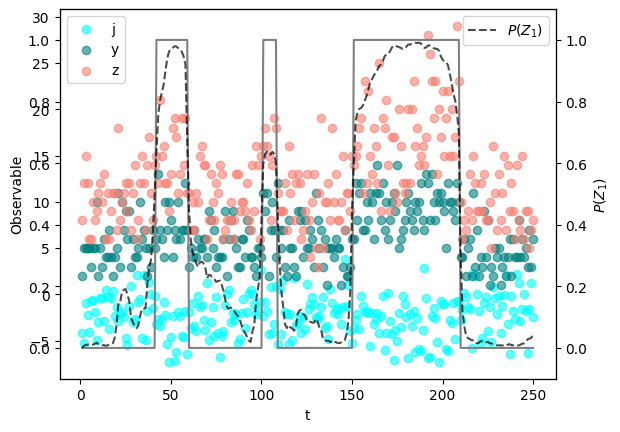

In [15]:
# define the Scipy functions
B_j_Z0 = stats.norm(mu_j*mu_scales[0], sigma_j)
B_j_Z1 = stats.norm(mu_j*mu_scales[1], sigma_j)

B_y_Z0 = stats.poisson(mu_y*mu_scales[0])
B_y_Z1 = stats.poisson(mu_y*mu_scales[1])

B_z_Z0 = stats.poisson(mu_z*mu_scales[0])
B_z_Z1 = stats.poisson(mu_z*mu_scales[1])

# store in correct format: list[tuple]
B_list = [(B_j_Z0, B_j_Z1), (B_y_Z0, B_y_Z1), (B_z_Z0, B_z_Z1)]
O_list = [df['j'].tolist(), df['y'].tolist(), df['z'].tolist()]

# create the BaumWelch (HMM) object
HMM = BaumWelch(
                    Z = {0,1},
                    O_list = O_list,
                    pi=[0.5, 0.5],
                    A=np.array([[0.8, 0.2], 
                                [0.2, 0.8]]),
                    B_list=B_list,
                )

# perform expectation maximisation
HMM.baumwelch_expectationMaximisation(iter=50, update_pi=True, update_A=True, update_B=False)

# inference
_, _, Z_inference, gamma_meanR = HMM.Z_state_probs_inference()

plot_hmm_results(df, Z_inference, gamma_meanR)

The results improve as more information is given to the model.

### HMM example: Three observed variables (j, y, z) and three hidden state {Z0, Z1, Z2}

We can also perform inference to find more than 2 hidden states. To do this, the parameters B_list, Z, pi, and A must be changed accordingly.

Early stopping converged on iteration 49.


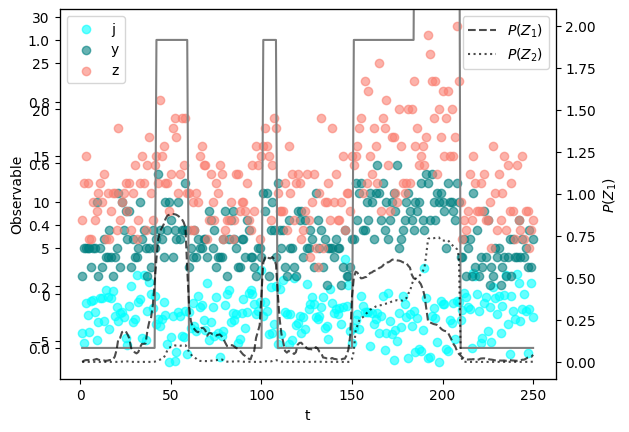

In [16]:
# define the Scipy functions
B_j_Z0 = stats.norm(mu_j*mu_scales[0], sigma_j)
B_j_Z1 = stats.norm(mu_j*mu_scales[1], sigma_j)
B_j_Z2 = stats.norm(mu_j*mu_scales[2], sigma_j)

B_y_Z0 = stats.poisson(mu_y*mu_scales[0])
B_y_Z1 = stats.poisson(mu_y*mu_scales[1])
B_y_Z2 = stats.poisson(mu_y*mu_scales[2])

B_z_Z0 = stats.poisson(mu_z*mu_scales[0])
B_z_Z1 = stats.poisson(mu_z*mu_scales[1])
B_z_Z2 = stats.poisson(mu_z*mu_scales[2])

# store in correct format: list[tuple]
B_list = [(B_j_Z0, B_j_Z1, B_j_Z2), (B_y_Z0, B_y_Z1, B_y_Z2), (B_z_Z0, B_z_Z1, B_z_Z2)]
O_list = [df['j'].tolist(), df['y'].tolist(), df['z'].tolist()]

# create the BaumWelch (HMM) object
HMM = BaumWelch(
                    Z = {0,1,2},
                    O_list = O_list,
                    pi=[0.34, 0.33, 0.33],
                    A=np.array([[0.6, 0.2, 0.2],
                                [0.2, 0.6, 0.2], 
                                [0.2, 0.2, 0.6]]),
                    B_list=B_list,
                )

# perform expectation maximisation
HMM.baumwelch_expectationMaximisation(iter=60, update_pi=True, update_A=True, update_B=False)

# inference
_, _, Z_inference, gamma_meanR = HMM.Z_state_probs_inference()

plot_hmm_results(df, Z_inference, gamma_meanR)

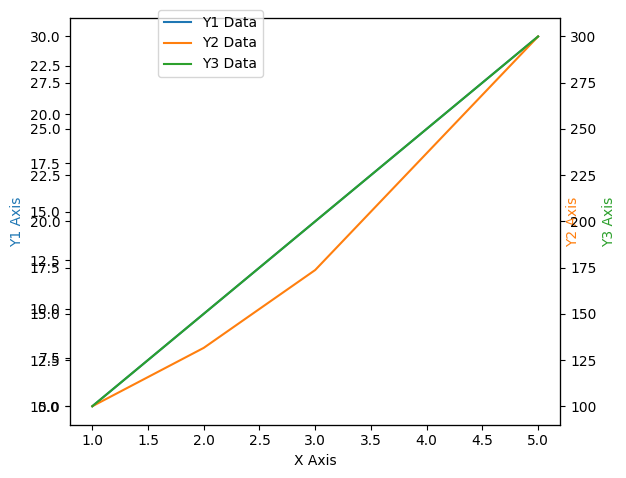

In [17]:
import matplotlib.pyplot as plt

# Sample data
x = [1, 2, 3, 4, 5]
y1 = [10, 15, 20, 25, 30]
y2 = [5, 8, 12, 18, 24]
y3 = [100, 150, 200, 250, 300]

fig, ax1 = plt.subplots()

# Plot data on the first y-axis
ax1.plot(x, y1, color='tab:blue', label='Y1 Data')
ax1.set_xlabel('X Axis')
ax1.set_ylabel('Y1 Axis', color='tab:blue')

# Create a twin axes for the first y-axis (second y-axis)
ax2 = ax1.twinx()

# Plot data on the second y-axis
ax2.plot(x, y2, color='tab:orange', label='Y2 Data')
ax2.set_ylabel('Y2 Axis', color='tab:orange')

# Create another twin axes for the second y-axis (third y-axis on the right)
ax3 = ax2.twinx()

# Plot data on the third y-axis
ax3.plot(x, y3, color='tab:green', label='Y3 Data')
ax3.set_ylabel('Y3 Axis', color='tab:green')

# Adjust the position of the third y-axis
ax3_pos = ax3.get_position()
ax3.set_position([ax3_pos.x0 + 0.1, ax3_pos.y0, ax3_pos.width, ax3_pos.height])

# Show the legend and display the plot
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 1))
plt.show()
